# Classifier Training
**This is trained on 4090 for 2 hours. This notebook doesn't need to be run.**

This note book shows the training process the classifier for gameswap and gamesale using bert-based model.

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from datasets import Dataset
import pandas as pd
import pickle
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

from datasets import load_dataset

# Load the dataset in pickle format
# created in 00_start.ipynb
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)
# Rename the columns to text and label
data.columns = ['text', 'label']
data.label = data.label.replace({'gamesale': 1, 'gameswap': 0})

## Load the training and test set.

In [2]:
# Split the data into train and test
training_proportion = 0.85
train_data = data[:int(len(data)*training_proportion)]
test_data = data[int(len(data)*training_proportion):]

In [3]:
# Load the dataset by dataframe
train_dataset = Dataset.from_pandas(train_data, split="train")
test_dataset = Dataset.from_pandas(test_data, split="test")

In [4]:
# Tokenize the data
train_dataset = train_dataset.map(lambda examples: tokenizer(examples["text"], truncation=True, padding="max_length"), batched=True)
test_dataset = test_dataset.map(lambda examples: tokenizer(examples["text"], truncation=True, padding="max_length"), batched=True)

Map:   0%|          | 0/29510 [00:00<?, ? examples/s]

Map:   0%|          | 0/5208 [00:00<?, ? examples/s]

## Load the pretrained model

In [5]:
# Get the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

## Finetune the model using our dataset.

In [6]:
# Train the model
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total # of training epochs
    per_device_train_batch_size=24,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/jliu/anaconda3/envs/torch3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 29510
  Num Epochs = 5
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 6150
  Number of trainable parameters = 108311810


Step,Training Loss
10,0.834500
20,0.761700
30,0.677100
40,0.626900
50,0.592500
60,0.533800
70,0.338700
80,0.231300
90,0.263600
100,0.145500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/c

TrainOutput(global_step=6150, training_loss=0.07841595214223716, metrics={'train_runtime': 1858.3086, 'train_samples_per_second': 79.4, 'train_steps_per_second': 3.309, 'total_flos': 3.8822036218368e+16, 'train_loss': 0.07841595214223716, 'epoch': 5.0})

In [7]:
# Evaluate the model
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5208
  Batch size = 64


{'eval_loss': 0.04026114568114281,
 'eval_runtime': 20.9206,
 'eval_samples_per_second': 248.941,
 'eval_steps_per_second': 3.92,
 'epoch': 5.0}

## Use the test set to check the performance.

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5208
  Batch size = 64


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5208
  Batch size = 64


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       1.00      0.99      1.00      3872

    accuracy                           0.99      5208
   macro avg       0.99      0.99      0.99      5208
weighted avg       0.99      0.99      0.99      5208



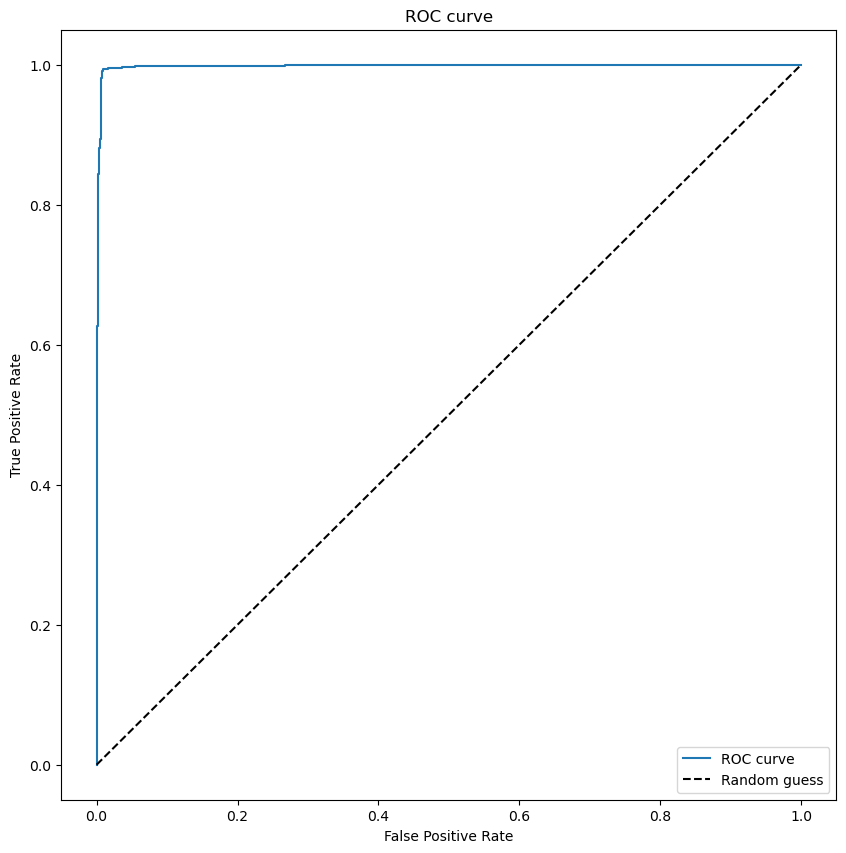

In [12]:
# Get the prediction
pred = trainer.predict(test_dataset)
pred = pred.predictions.argmax(axis=-1)

# Get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_data['label'], pred)

# Get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_data['label'], pred)

# Get the classification report
from sklearn.metrics import classification_report
print(classification_report(test_data['label'], pred))

# Get the ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Get the probability
pred_prob = trainer.predict(test_dataset)
pred_prob = pred_prob.predictions[:, 1]

# Get the fpr, tpr, and threshold
fpr, tpr, threshold = roc_curve(test_data['label'], pred_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig('plot/ROC.png',dpi=300)
plt.show()


In [18]:
# Use the model to predict another text
text = "I want to sell my game"
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to('cuda')
output = model(**encoded_input)
output = output.logits.argmax(axis=-1)
print(output)
# i.e. sale. The model predicts correctly.

tensor([1], device='cuda:0')
